<h2>Project 2: Advanced Lane Finding</h2><br>
<h5>The final project video is saved in output_images. There is a prerecorded video incase you don't want to wait. Run the file and wait for 200 seconds, a message "Done! Videos are saved in output_images folder!" will print when the video is saved. </h5>

<h5>We begin with the camera calibration to retrieve camera matrix ands distortion points. </h5>

Text(0.5,1,'undistorted')

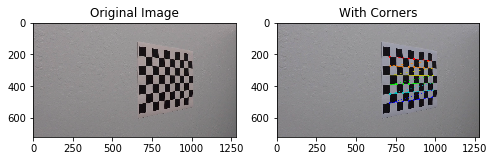

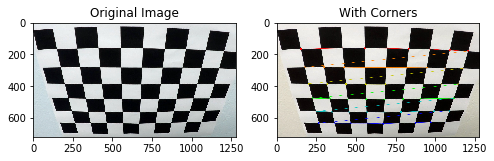

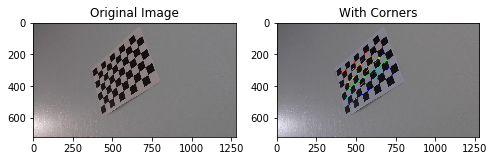

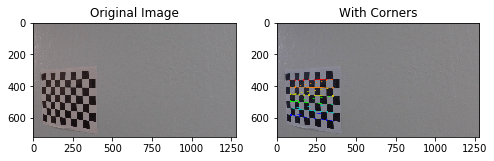

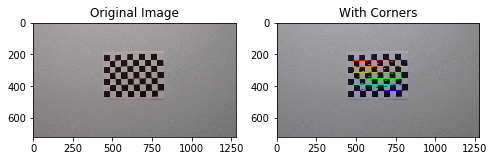

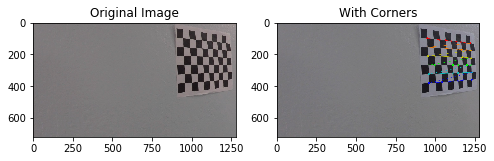

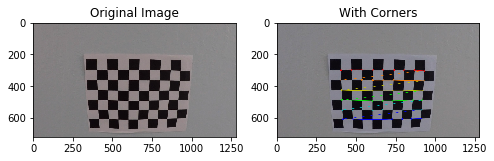

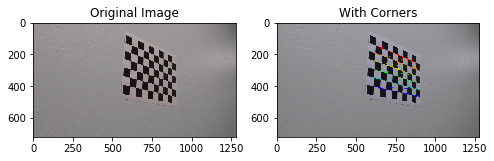

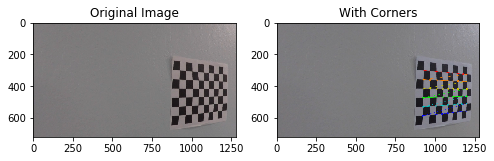

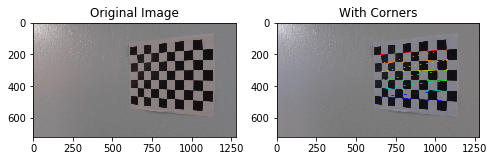

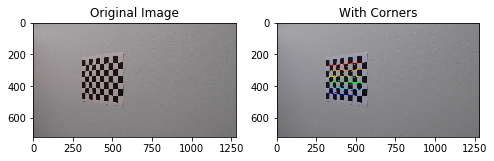

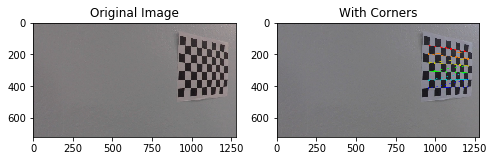

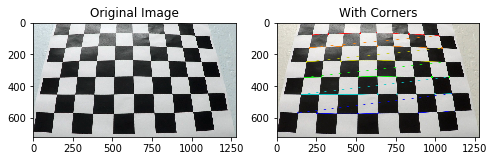

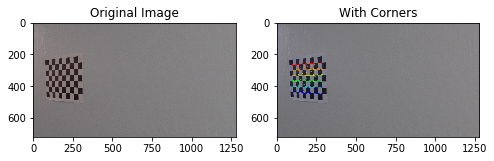

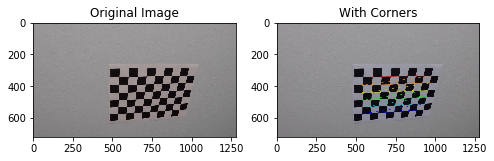

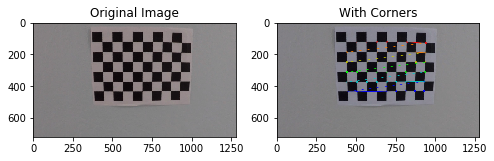

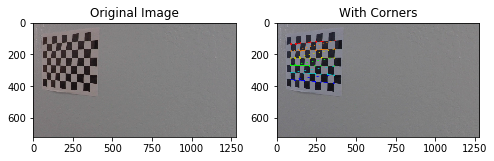

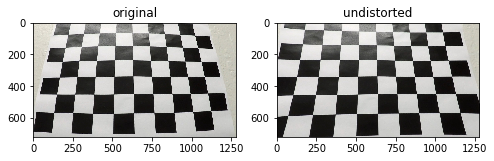

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
from matplotlib.lines import Line2D
import sys
%matplotlib inline
import os
import math
import time

nx = 9
ny = 6
#A matrix is created of shape (54,3)in float32
objp = np.zeros((nx*ny,3), np.float32)

#Matrix is reshaped to 2 (9,6) mgrids
#Then transposed to display (54, 2)
objp[:,:2]=np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

#Arrays to hold object & image points
objpoint = [] #3D points for real world plane
imgpoint = [] #2D points for image plane

images = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoint.append(objp)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11), (-1,-1),criteria)
        imgpoint.append(corners2)
        img = cv2.drawChessboardCorners(img,(nx,ny), corners2,ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners')

        
#Calibrating the image
ret, mtx, dist,rvecs,tvecs = cv2.calibrateCamera(objpoint, imgpoint, gray.shape[::-1],None,None)

#Undistorting the image
img = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration3.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)

#x,y,w,h = roi
#dst = dst[y:y+h, x:x+w]
f, (ax, ax0) = plt.subplots(1,2, figsize=(8,4))
ax.imshow(img)
ax.set_title('original')
ax0.imshow(dst)
ax0.set_title('undistorted')



<h3>Now let's try to see the pipeline through an image.</h3>
<h5>
1. Read in an image<br>
2. Undistort the image using camera calibration points<br>
3. Color/Gradient Threshold <br>
4. Warping the image for bird eye perspective<br>
5. Detect the lane lines using sliding window<br>
6. Determine lane curvature.</h5>


Text(0.5,1,'Poly Lines for region of interest')

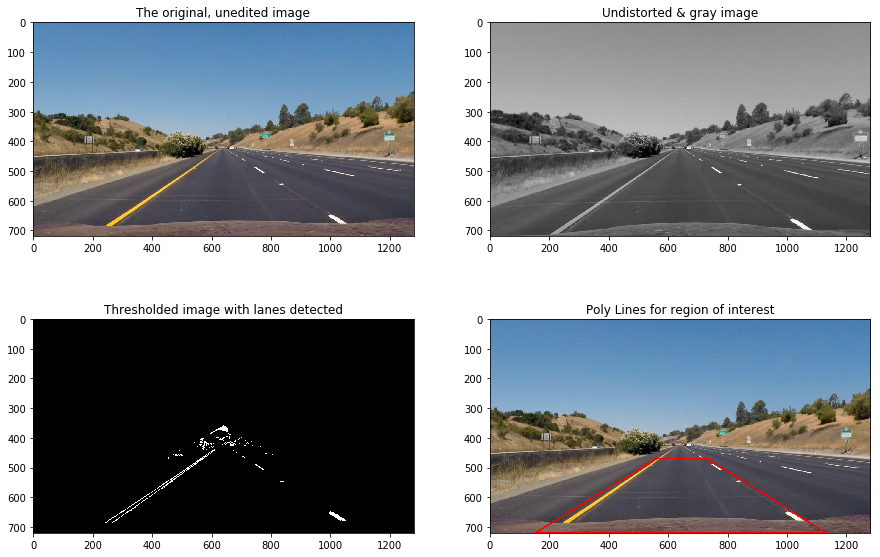

In [6]:

#Read in the image and turn to gray

img = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

#Undistort the image using camera matrices we got from camera calibration
undistorted = cv2.undistort(img, newcameramtx, dist, None, newcameramtx)
gray = cv2.cvtColor(undistorted,cv2.COLOR_BGR2GRAY)
imgshape = gray.shape
f, ax = plt.subplots(2,2)
f.set_size_inches(15, 10)
ax[0,0].imshow(img)
ax[0,1].imshow(gray, cmap='gray')
ax[0,0].set_title("The original, unedited image")
ax[0,1].set_title("Undistorted & gray image")
#Now we mask the image to find the color thresholds we are looking for
#which is the yellow/white lanes

R = img[:,:,2]
G = img[:,:,1]
B = img[:,:,0]
rbinary = np.zeros_like(R)
rbinary[(R>180) & (R<255)]=1

luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
L_luv = luv[:,:,2]
U = luv[:,:,1]
V = luv[:,:,0]
lbinary = np.zeros_like(L_luv)
lbinary[(L_luv > 150) & (L_luv <=255)] = 1

lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
#L_lab = img[:,:,2]
A = lab[:,:,1]
B = lab[:,:,0]
bbinary = np.zeros_like(B)
bbinary[(B > 180) & (B <= 255)] = 1

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
L = hls[:,:,1]
S = hls[:,:,2]

#Apply sobel edge detection
sx_thresh = (20,100)
#Take derivative in x & y direction
sx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=3)
sy = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=3)

#Get absolute for x & y direction
abs_sx = np.absolute(sx)
abs_sy = np.absolute(sy)

scaled_sobel = np.uint8(255*abs_sx/np.max(abs_sx))

#X gradient threshold
sxbinary = np.zeros_like(scaled_sobel)
#thresh_binx = np.zeros_like(bin_x)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
sbinary = np.zeros_like(S)
sbinary[(S >= 150) & (S <=255)] = 1

color_binary = np.stack((np.zeros_like(sxbinary), sxbinary, sbinary)) * 255
combined_bin = np.zeros_like(sxbinary)
combined_bin[((sbinary == 1) & (sxbinary == 1)) | (rbinary == 1) | (lbinary == 1 ) & (sxbinary == 1)| ((bbinary == 1) & (sxbinary == 1))] = 1
color = combined_bin
mask = np.zeros_like(color)
y, x = gray.shape
v = [[0, (y-1)], [(x/2),(int(0.5*y))], [(x-1), (y-1)]]
roi = np.array(v, dtype=np.int32)
cv2.fillPoly(mask, [roi], 1)
thresholded = cv2.bitwise_and(color, mask)

ax[1,0].imshow(thresholded, cmap='gray')
ax[1,0].set_title("Thresholded image with lanes detected")

#Now get polylines for region of interest
lower_left = [150, 720]; lower_right = [1130, 720]
upper_left = [560, 470]; upper_right = [730, 470]

vertices = [lower_left,lower_right,upper_right,upper_left]
pts = np.array(vertices, np.int32)
pts = pts.reshape((-1,1,2))
poly = img.copy()
cv2.polylines(poly,[pts],True,(255,0,0), thickness=3)
ax[1,1].imshow(poly)
ax[1,1].set_title("Poly Lines for region of interest")

<h3>Next, we warp the image to get the bird-eye perspective</h3

Text(0.5,1,'Thresholded, warped image')

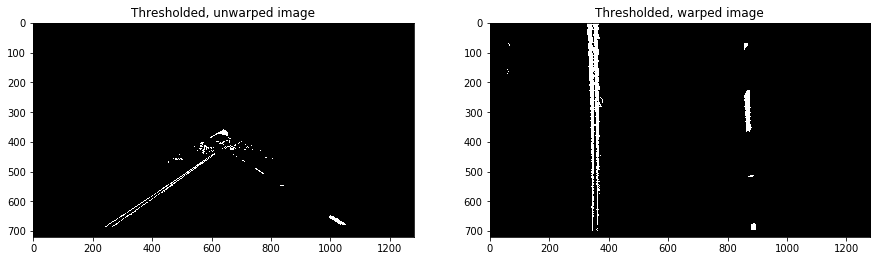

In [7]:
dst = np.float32([[320,720],[900,720],[900,1],[320,1]])
src = np.float32(vertices)

M_inv = cv2.getPerspectiveTransform(dst, src) #We will later need this to unwarp the image
M = cv2.getPerspectiveTransform(src, dst) #We use this for warping
img_shape = (imgshape[1], imgshape[0])
warped = cv2.warpPerspective(thresholded, M, img_shape, flags=cv2.INTER_LINEAR)


f, ax = plt.subplots(1,2)
f.set_size_inches(15, 10)
ax[0].imshow(thresholded, cmap='gray')
ax[0].set_title("Thresholded, unwarped image")
ax[1].imshow(warped, cmap='gray')
ax[1].set_title("Thresholded, warped image")

<function matplotlib.pyplot.show(*args, **kw)>

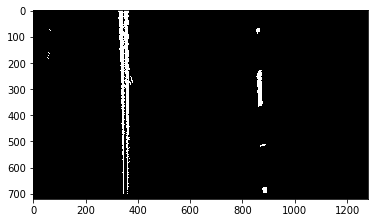

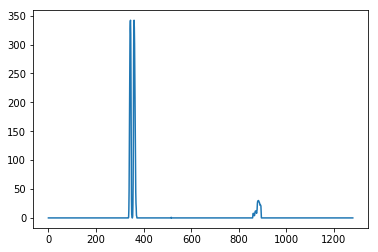

In [8]:
#Histogram to determine color peaks
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.imshow(warped, cmap='gray')
plt.figure()
plt.plot(histogram)
plt.show

<h3>Now, we go detect lanes through window sliding</h3>

Text(0.5,1,'Polyfill between lanes')

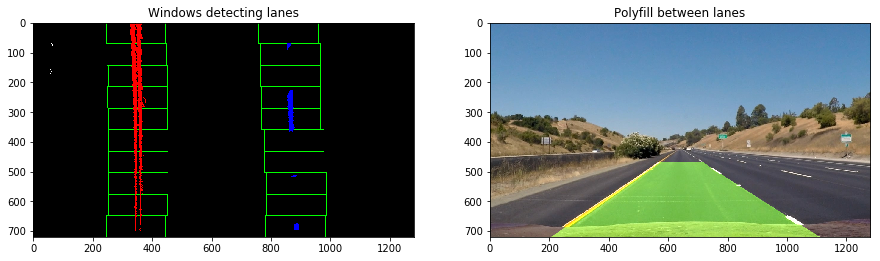

In [9]:
#First, let's get the left and right base from histogram
rows = warped.shape[0]
midpoint = np.int(histogram.shape[0]/2) #Half-width
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#Now we determine the number of windows, margin and pixel thresholds
windows = 10
margin = 100
pix = 50
#Create blank arrays for lane detections

#Sliding window detection
win_img = np.dstack((warped, warped, warped))*255
nz_y = (warped.nonzero()[0])
nz_x = (warped.nonzero()[1])
y_pts = np.linspace(0, rows-1, rows)
rows = warped.shape[0]
height = np.int(rows/windows)
leftx = leftx_base
rightx = rightx_base
left_pts = []
right_pts = []
for window in range(windows):
    ymax = rows - (window*height)
    ymin = rows - ((window+1)*height)
    xleftmax = leftx + margin
    xleftmin = leftx - margin
    xrightmax = rightx + margin
    xrightmin = rightx - margin
    
    #Drawing windows
    cv2.rectangle(win_img, (xleftmin, ymin), (xleftmax, ymax), (0,255,0),2)
    cv2.rectangle(win_img, (xrightmin, ymin), (xrightmax, ymax), (0,255,0),2)
    good_left_pts = ((nz_y >= ymin) & (nz_y < ymax) & (nz_x >= xleftmin) & (nz_x < xleftmax)).nonzero()[0]
    good_right_pts = ((nz_y >= ymin) & (nz_y < ymax) & (nz_x >= xrightmin) & (nz_x < xrightmax)).nonzero()[0]
    left_pts.append(good_left_pts)
    right_pts.append(good_right_pts)
    
    if len(good_left_pts) > pix:
        leftx = np.int(np.mean(nz_x[good_left_pts]))

    if len(good_right_pts) > pix:
        rightx = np.int(np.mean(nz_x[good_right_pts]))

left_pts = np.concatenate(left_pts)
right_pts = np.concatenate(right_pts)
left_linex = nz_x[left_pts]
left_liney = nz_y[left_pts]
right_linex = nz_x[right_pts]
right_liney = nz_y[right_pts]
leftfit = np.polyfit(left_liney, left_linex, 2)
rightfit = np.polyfit(right_liney, right_linex, 2)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
leftfitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
rightfitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
win_img[nz_y[left_pts], nz_x[left_pts]] = [255, 0, 0]
win_img[nz_y[right_pts], nz_x[right_pts]] = [0, 0, 255]
#plt.figure()
#plt.imshow(win_img)
f, ax = plt.subplots(1,2)
f.set_size_inches(15, 10)
ax[0].imshow(win_img, cmap='gray')
ax[0].set_title("Windows detecting lanes")
win_img = np.dstack((warped, warped, warped))*255

leftline_win = np.array(np.transpose(np.vstack([leftfitx, y_pts])))
rightline_win = np.flipud(np.transpose(np.vstack([rightfitx, y_pts])))
line_pts = np.vstack((leftline_win, rightline_win))

#Fill in the lane at line_pts

cv2.fillPoly(win_img, np.int_([line_pts]), [100,255,0])
warp_new = cv2.warpPerspective(win_img, M_inv, img_shape, flags=cv2.INTER_LINEAR)

res = cv2.addWeighted(img, 1, warp_new, 0.5, 0)
ax[1].imshow(res, cmap='gray')
ax[1].set_title("Polyfill between lanes")

<h3>For the actual process, we also add curvature and radius as the car moves on the road. The following has all the functions necessary for the pipeline.</h3>


In [6]:
#Necessary functions

def get_undistorted(img, newcameramtx, dist):
    undistorted = cv2.undistort(img, newcameramtx, dist, None, newcameramtx)
    return undistorted

def get_warped(image, imgshape, src, dst):
    img_shape = (imgshape[1],imgshape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_shape, flags=cv2.INTER_LINEAR)

    return warped

def binary_thresh(channel, thresh = (130, 255), on = 1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

        return binary
    
def sobel_process(img, gray):
    kernel=3
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    rbinary = np.zeros_like(R)
    rbinary[(R > 200) & (R <= 255)] = 1
    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L_luv = luv[:,:,2]
    U = luv[:,:,1]
    V = luv[:,:,0]
    lbinary = np.zeros_like(L_luv)
    lbinary[(L_luv > 180) & (L_luv <=255)] = 1
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    #L_lab = img[:,:,2]
    A = lab[:,:,1]
    B = lab[:,:,0]
    bbinary = np.zeros_like(B)
    bbinary[(B > 180) & (B <= 255)] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    #Apply sobel edge detection
    sx_thresh = (20,100)
    #Take derivative in x & y direction
    sx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=3)
    sy = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=3)

    #Get absolute for x & y direction
    abs_sx = np.absolute(sx)
    abs_sy = np.absolute(sy)

    scaled_sobel = np.uint8(255*abs_sx/np.max(abs_sx))

    #X gradient threshold
    sxbinary = np.zeros_like(scaled_sobel)
    #thresh_binx = np.zeros_like(bin_x)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    sbinary = np.zeros_like(S)
    sbinary[(S >= 90) & (S <=255)] = 1

    color_binary = np.stack((np.zeros_like(sxbinary), sxbinary, sbinary)) * 255
    combined_bin = np.zeros_like(sxbinary)
    combined_bin[((sbinary == 1) & (sxbinary == 1)) | (rbinary == 1) | (lbinary == 1 ) & (sxbinary == 1)| ((bbinary == 1) & (sxbinary == 1))] = 1

    color = combined_bin
    mask = np.zeros_like(color)
    y, x = gray.shape
    v = [[0, (y-1)], [(x/2),(int(0.5*y))], [(x-1), (y-1)]]
    roi = np.array(v, dtype=np.int32)
    cv2.fillPoly(mask, [roi], 1)
    thresholded = cv2.bitwise_and(color, mask)
    #thresholded = get_undistorted(thresholded, newcameramtx, dist)
    
    return thresholded


def get_pts(img):
    
    nz = img.nonzero()
    nz_y = nz[0]
    nz_x = nz[1]
    rows = img.shape[0]
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    hw = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:hw])
    rightx_base = np.argmax(histogram[hw:]) + hw
    windows = 10
    h = np.int(rows/windows)
    margin = 100
    pix = 50
    
    left_pts = []
    right_pts = []
    
    for window in range(windows):
        ymax = rows - window*h
        ymin = rows - (window+1) * h
        xleftmin = leftx_base - margin
        xleftmax = leftx_base + margin
        xrightmin = rightx_base - margin
        xrightmax = rightx_base + margin
        good_left_pts = ((nz_y >= ymin) & (nz_y < ymax) & (nz_x >= xleftmin) & (nz_x < xleftmax)).nonzero()[0]
        good_right_pts = ((nz_y >= ymin) & (nz_y < ymax) & (nz_x >= xrightmin) & (nz_x < xrightmax)).nonzero()[0]
        left_pts.append(good_left_pts)
        right_pts.append(good_right_pts)
        if len(good_left_pts) > pix:
            leftx_base = np.int(np.mean(nz_x[good_left_pts]))
        if len(good_right_pts) > pix:
            rightx_base = np.int(np.mean(nz_x[good_right_pts]))
        
    left_pts = np.concatenate(left_pts)
    right_pts = np.concatenate(right_pts)
    
    leftfitx, rightfitx = line_fit(nz_x, nz_y, left_pts, right_pts, rows)
    
    return leftfitx, rightfitx
    
def line_fit(nz_x, nz_y, left_pts, right_pts, rows):
    
    leftx = nz_x[left_pts]
    lefty = nz_y[left_pts]
    rightx = nz_x[right_pts]
    righty = nz_y[right_pts]

    if(lefty.size == 0 or leftx.size == 0):
        return None, None
    left_polyfit = np.polyfit(lefty, leftx, 2)

    if(rightx.size == 0 or righty.size == 0):
        return None, None
    right_polyfit = np.polyfit(righty, rightx, 2)
    y_pts = np.linspace(0, rows-1, rows)
    leftfitx = left_polyfit[0]*y_pts**2 + left_polyfit[1]*y_pts + left_polyfit[2]
    rightfitx = right_polyfit[0]*y_pts**2 + right_polyfit[1]*y_pts + right_polyfit[2]

    return leftfitx, rightfitx

def avg_line(oldline, linefitx):
    n = 12
    
    if linefitx is None:
        if len(oldline) == 0:
            return oldline, None
        else:
            return oldline, oldline[-1]
    else:
        if len(oldline) < n:
            oldline.append(linefitx)
            return oldline, linefitx
        else:
            oldline[0:n-1] = oldline[1:]
            oldline[n-1] = linefitx
            linefitx = np.zeros_like(linefitx)
            for i in range(n):
                linefitx += oldline[i]
            linefitx /= n
            return oldline, linefitx

def avg_radius(left_value, right_value, rows):
    y_perpix = 30/720
    x_perpix = 3.7/700
    y_pts = np.linspace(0, rows-1, rows)
    y_eval = np.max(y_pts)

    left_fit_curve = np.polyfit(y_pts*y_perpix, left_value*x_perpix, 2)
    left_curve_rad = ((1 + (2*left_fit_curve[0]*y_eval*y_perpix + left_fit_curve[1])**2)**1.5) / np.absolute(2*left_fit_curve[0])
    right_fit_curve = np.polyfit(y_pts*y_perpix, right_value*x_perpix, 2)
    right_curve_rad = ((1 + (2*right_fit_curve[0]*y_eval*y_perpix + right_fit_curve[1])**2)**1.5) / np.absolute(2*right_fit_curve[0])

    avg = (left_curve_rad + right_curve_rad) / 2

    return avg
    
def process_img(img):
    
    global left_polyfit
    global right_polyfit
    global old_left_line
    global old_right_line
    global current_mean_diff
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgshape = gray.shape
    thresholded = sobel_process(img, gray)
    #plt.figure()
    #plt.imshow(thresholded, cmap='gray')
    lower_left = [150, 720]; lower_right = [1130, 720]
    upper_left = [560, 470]; upper_right = [730, 470]
    vertices = [lower_left,lower_right,upper_right,upper_left]
    pts = np.array(vertices, np.int32)
    pts = pts.reshape((-1,1,2))
    poly = img.copy()
    cv2.polylines(poly,[pts],True,(255,0,0), thickness=3)
    img_size = (imgshape[1], imgshape[0])
    #plt.figure()
    #plt.imshow(poly)
    dst = np.float32([[320,720],[900,720],[900,1],[320,1]])
    src = np.float32(vertices)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = get_warped(thresholded, imgshape, src, dst)
    
    #get_pts(img, leftx_base, rightx_base, windows, margin, pix)
    #plt.figure()
    #plt.imshow(warped, cmap='gray')
    win_img = np.dstack((warped, warped, warped))*255
    #half_w = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:half_w])
    #rightx_base = np.argmax(histogram[half_w:]) + half_w
    nz_y = (warped.nonzero()[0])
    nz_x = (warped.nonzero()[1])
    windows = 10
    rows = warped.shape[0]
    height = np.int(rows/windows)
    margin = 100
    pix = 50
    y_pts = np.linspace(0, rows-1, rows)
    #Creating sliding window detection
    if (left_polyfit is None) or (right_polyfit is None):
        search = True
        leftfitx, rightfitx = get_pts(warped)
    else:
        search = False
        margin = 100
        leftfitx = left_polyfit[0]*nz_y**2 + left_polyfit[1]*nz_y + left_polyfit[2]
        rightfitx = right_polyfit[0]*nz_y**2 + right_polyfit[1]*nz_y + right_polyfit[2]
        left_pts = ((nz_x >= leftfitx - margin) & (nz_x <= leftfitx + margin)).nonzero()[0]
        right_pts = ((nz_x >= rightfitx - margin) & (nz_x <= rightfitx + margin)).nonzero()[0]

        leftfitx, rightfitx = line_pts(nz_x, nz_y, left_pts, right_pts, rows)

    if (leftfitx is None or rightfitx is None):
        if not search:
            leftfitx, rightfitx = get_pts(warped)

        bad_lines = False
    if (leftfitx is None or rightfitx is None):
        bad_lines = True
    else:
        mean_diff = np.mean(rightfitx - leftfitx)

        if current_mean_diff == 0:
            current_mean_diff = mean_diff
        if (mean_diff < 0.7*current_mean_diff or mean_diff > 1.3*current_mean_diff):
            bad_lines = True

            if not search:
                leftfitx, rightfitx = get_pts(warped)
                if (leftfitx is None or rightfitx is None):
                    bad_lines = True
                else:
                    mean_diff = np.mean(rightfitx - leftfitx)
                    if (mean_diff < 0.7*current_mean_diff or mean_diff > 1.3*current_mean_diff):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
    if bad_lines:
        left_polyfit = None
        right_polyfit = None
        if len(old_left_line) == 0 and len(old_right_line) == 0:
            return img
        else:
            leftfitx = old_left_line[-1]
            rightfitx = old_right_line[-1]

    else:
        old_left_line, leftfitx = avg_line(old_left_line, leftfitx)
        old_right_line, rightfitx = avg_line(old_right_line, rightfitx)
        mean_diff = np.mean(rightfitx - leftfitx)
        current_mean_diff = 0.9*current_mean_diff + 0.1*mean_diff
        leftline_win = np.array(np.transpose(np.vstack([leftfitx, y_pts])))
        rightline_win = np.flipud(np.transpose(np.vstack([rightfitx, y_pts])))
        x_perpix = 3.7/700
        avg_rad = avg_radius(leftfitx, rightfitx, rows)
        lane_center = (rightfitx[-1] + leftfitx[-1]) / 2
        center_pix = abs(imgshape[1]/2 - lane_center)
        center_mtrs = x_perpix*center_pix
        offset_str = "Radius of curvature: %.2f m " % avg_rad + "Center offset: %.2f m" % center_mtrs

        poly_pts = np.vstack([leftline_win, rightline_win])
        cv2.fillPoly(win_img, np.int_([poly_pts]), [0,255,0])
        unwarped = cv2.warpPerspective(win_img, M_inv, img_size, flags=cv2.INTER_LINEAR)

        final = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

        cv2.putText(final, offset_str, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (20,255,255), thickness=2)
        
        return final



In [7]:
yellow_line = cv2.VideoCapture('../CarND-Advanced-Lane-Lines/project_video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
yellow_out = cv2.VideoWriter('../CarND-Advanced-Lane-Lines/output_images/project_video_Prerecord.mp4',fourcc, 10.0, (1280,720))

timeout1 = time.time() + (200)

while(True):
    if time.time() > timeout1:
            break
    #Read in the frame
    ret, frame = yellow_line.read()
    if ret == True:
        img = frame.copy()
        #plt.imshow(frame)
        undistort = get_undistorted(img, newcameramtx, dist)
        #plt.imshow(img)
        left_polyfit = None
        right_polyfit = None
        old_left_line = []
        old_right_line = []
        current_mean_diff = 0
        processed = process_img(undistort)
        #plt.figure()
        #plt.imshow(processed)
        #Show/save the video with detected lanes
        yellow_out.write(processed)
        #Uncoment the following lines to see the videos 
        #in a separate window if not using jupyter on workspace
        #cv2.imshow('Yellow Edges', processed)

#yellow_line.release()
yellow_out.release()
print("Done! Videos are saved in test_videos_output folder!!")
#cv2.destroyAllWindows()
sys.exit()

Done! Videos are saved in test_videos_output folder!!


SystemExit: 

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
